In [174]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'gender_submission.csv']


In [175]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
gender = pd.read_csv("../input/gender_submission.csv")

In [176]:
full = pd.concat([train,test])

In [177]:
full["title"] = (full["Name"].apply(lambda x: x.split(",")[1])).apply(lambda x: x.split(".")[0])

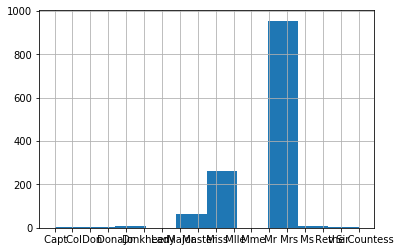

In [178]:
full.title.hist()

In [179]:
full.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


In [180]:
print("percentage of missing cabin no.",sum(full.Cabin.isnull())/full.Cabin.shape[0] * 100)

percentage of missing cabin no. 77.46371275783041


In [181]:
full["Cabin"] = full.Cabin.fillna("missing")

In [182]:
for i in full.columns:
    print("percentage of missing ",i ,sum(full[i].isnull())/full[i].shape[0] * 100)

percentage of missing  Age 20.091673032849503
percentage of missing  Cabin 0.0
percentage of missing  Embarked 0.15278838808250572
percentage of missing  Fare 0.07639419404125286
percentage of missing  Name 0.0
percentage of missing  Parch 0.0
percentage of missing  PassengerId 0.0
percentage of missing  Pclass 0.0
percentage of missing  Sex 0.0
percentage of missing  SibSp 0.0
percentage of missing  Survived 31.932773109243694
percentage of missing  Ticket 0.0
percentage of missing  title 0.0


In [183]:
full["Age"] = full["Age"].fillna("missingage")
full["Embarked"] = full["Embarked"].fillna("not avail")
full["Fare"] = full["Fare"].fillna(full["Fare"].mean())

In [184]:
full.drop("Survived",axis = 1,inplace = True)
full.drop("Ticket",axis = 1, inplace = True)
full.drop("Name",axis = 1, inplace = True)


In [185]:
full.drop("PassengerId",axis = 1, inplace = True)
full.head()

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,title
0,22,missing,S,7.2500,0,3,male,1,Mr
1,38,C85,C,71.2833,0,1,female,1,Mrs
2,26,missing,S,7.9250,0,3,female,0,Miss
3,35,C123,S,53.1000,0,1,female,1,Mrs
4,35,missing,S,8.0500,0,3,male,0,Mr


In [186]:
full["Age"] = full["Age"].apply(lambda x: str(x))

In [187]:
full["Parch"] = full["Parch"].apply(lambda x: str(x))

In [188]:
full["Pclass"] = full["Pclass"].apply(lambda x: str(x))

In [189]:
full["SibSp"] = full["SibSp"].apply(lambda x: str(x))

In [190]:
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
cv = CountVectorizer()
x_age = cv.fit_transform(full["Age"])
x_cabin = cv.fit_transform(full["Cabin"])
x_embarked = cv.fit_transform(full["Embarked"])
x_sex = cv.fit_transform(full["Sex"])
x_title = cv.fit_transform(full["title"])

In [191]:
from sklearn.preprocessing import OneHotEncoder
encode = OneHotEncoder()
x_parch = encode.fit_transform(full["Parch"].reshape(-1,1))
x_pclass = encode.fit_transform(full["Pclass"].reshape(-1,1))
x_sib = encode.fit_transform(full["SibSp"].reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [192]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_fare = sc.fit_transform(full["Fare"].reshape(-1,1))
x_fare = sparse.csr_matrix(x_fare)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [193]:
x = sparse.hstack([x_age,x_cabin,x_embarked,x_sex,x_title,x_pclass,x_parch,x_sib,x_fare])
x_train = x.tocsr()[:791,:]
x_valid = x.tocsr()[791:891,:]
x_test = x.tocsr()[891:,:] 
y_train = train["Survived"][:791]
y_valid = train["Survived"][791:891]

In [194]:
import lightgbm as lgb
train_data = lgb.Dataset(x_train,label = y_train)
valid_data = lgb.Dataset(x_valid, label = y_valid)


In [195]:
params = {
     'objective' :'binary',
    'metric': 'binary_logloss',
    'learning_rate' : 0.001,
    'verbose' : 1,
}
model = lgb.train(params, train_data, valid_sets= valid_data, num_boost_round=300,early_stopping_rounds=20)

[1]	valid_0's binary_logloss: 0.69263
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's binary_logloss: 0.692114
[3]	valid_0's binary_logloss: 0.691599
[4]	valid_0's binary_logloss: 0.691085
[5]	valid_0's binary_logloss: 0.690572
[6]	valid_0's binary_logloss: 0.69006
[7]	valid_0's binary_logloss: 0.689549
[8]	valid_0's binary_logloss: 0.689039
[9]	valid_0's binary_logloss: 0.68853
[10]	valid_0's binary_logloss: 0.688023
[11]	valid_0's binary_logloss: 0.687516
[12]	valid_0's binary_logloss: 0.68701
[13]	valid_0's binary_logloss: 0.686505
[14]	valid_0's binary_logloss: 0.686002
[15]	valid_0's binary_logloss: 0.685499
[16]	valid_0's binary_logloss: 0.684997
[17]	valid_0's binary_logloss: 0.684496
[18]	valid_0's binary_logloss: 0.683997
[19]	valid_0's binary_logloss: 0.683498
[20]	valid_0's binary_logloss: 0.683
[21]	valid_0's binary_logloss: 0.682503
[22]	valid_0's binary_logloss: 0.682008
[23]	valid_0's binary_logloss: 0.681513
[24]	valid_0's binary_logloss: 0.6

[216]	valid_0's binary_logloss: 0.600576
[217]	valid_0's binary_logloss: 0.600208
[218]	valid_0's binary_logloss: 0.599892
[219]	valid_0's binary_logloss: 0.599525
[220]	valid_0's binary_logloss: 0.599179
[221]	valid_0's binary_logloss: 0.598845
[222]	valid_0's binary_logloss: 0.598485
[223]	valid_0's binary_logloss: 0.598172
[224]	valid_0's binary_logloss: 0.597827
[225]	valid_0's binary_logloss: 0.597465
[226]	valid_0's binary_logloss: 0.597142
[227]	valid_0's binary_logloss: 0.59678
[228]	valid_0's binary_logloss: 0.596439
[229]	valid_0's binary_logloss: 0.596098
[230]	valid_0's binary_logloss: 0.595758
[231]	valid_0's binary_logloss: 0.595429
[232]	valid_0's binary_logloss: 0.59509
[233]	valid_0's binary_logloss: 0.594733
[234]	valid_0's binary_logloss: 0.5944
[235]	valid_0's binary_logloss: 0.594062
[236]	valid_0's binary_logloss: 0.593726
[237]	valid_0's binary_logloss: 0.59339
[238]	valid_0's binary_logloss: 0.593054
[239]	valid_0's binary_logloss: 0.59272
[240]	valid_0's binary

In [196]:
pred = model.predict(x_test)

In [197]:
gender["Survived"] = pred >= 0.5
gender["Survived"] = gender["Survived"].apply( lambda x : int(x))
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [198]:
gender.to_csv("2_attempt.csv", index = False)